# Libraries

In [1]:
import numpy as np
import pandas as pd
from darts.models import AutoARIMA
from darts.metrics import smape
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
%matplotlib inline


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_file="full_df.csv"
date_column_name = 'reporting_time'
no_months = 50

# Loading of dataset
df_origin = pd.read_csv('full_df.csv', parse_dates=['reporting_time']).drop('Unnamed: 0', axis =1)

#delete discontinuing products
df_continue = df_origin[df_origin['reporting_time']=='2023-02-01T00:00:00.000Z']
df_continue_origin = df_origin[df_origin['product_name'].isin(df_continue['product_name'])]

df_continue_origin['reporting_time'] = pd.to_datetime(df_continue_origin['reporting_time'], utc=True)
df_continue_origin['reporting_time'] = df_continue_origin['reporting_time'].dt.tz_localize(None)
df_continue_origin.set_index('reporting_time', inplace=True)

sub_df = df_continue_origin[df_continue_origin.groupby('product_name').product_name.transform('count')>=no_months].copy()

train = 0.8
val = 0.2

all_prod_names = list(sub_df['product_name'].unique())

forecast_length = 18

# Functions

In [3]:
def smape_func_darts(a, f):
    a = TimeSeries.pd_series(a)
    f = TimeSeries.pd_series(f)
    numerator = np.sum(np.abs(a-f))
    denominator = np.sum(a+f)
    return numerator/denominator

In [4]:
metrics_df = pd.DataFrame({'product_name' : all_prod_names})
metric_list = []


# print('start of loop')
for name in all_prod_names:
    # initialize scalers
    scaler_train = Scaler()
    scaler_val_all = Scaler()
    scaler_val_uni = Scaler()
    
    # subsetting dataframe
    prod_df = sub_df[sub_df['product_name']==name][['demand']]
    darts_df = TimeSeries.from_dataframe(prod_df, freq='MS', fillna_value=prod_df['demand'].mean())
    train_set, val_set= darts_df.split_before(train)

    # fit scalers
    train_set = scaler_train.fit_transform(train_set)
    val_set_all = scaler_val_all.fit_transform(val_set)
    val_set_uni = scaler_val_uni.fit_transform(val_set['demand'])

    model_aarima = AutoARIMA(information_criterion = 'hqic')
    model_aarima.fit(series = train_set['demand'])
    forecast = model_aarima.predict(len(val_set)+forecast_length)

    # inverse forecasts to original magnittude
    forecast = scaler_val_uni.inverse_transform(forecast)
    forecast = TimeSeries.pd_dataframe(forecast)

    # set forecasted 0s to be 0.0001 such that smape can be calculated 
    forecast['demand'] = forecast['demand'].apply(lambda x: x if x>0 else 0.0001)
    forecast = TimeSeries.from_dataframe(forecast)
    metric_score = 1 - smape_func_darts(val_set['demand'], forecast[:len(val_set)])
    metric_list.append(metric_score)

    # plotting result
    plt.plot(TimeSeries.pd_series(darts_df['demand']), label = 'historical')
    plt.plot(TimeSeries.pd_series(forecast['demand'][:len(val_set)]), label = 'val_set')
    plt.plot(TimeSeries.pd_series(forecast['demand'][-forecast_length:]), label = 'forecast')
    plt.legend()
    plt.title(f'Product {name}, Accuracy: {metric_score}')
    plt.savefig(f'output/AutoArima/graphs/{name}.png')
    plt.close()

    model_aarima.save(f'output/AutoArima/models/{name}.pkl')

metrics_df['Accuracy_Score'] = metric_list


metrics_df.to_csv('output/AutoArima/Arima_score.csv')
print('completed')



c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\melov\Documents\Git

completed


In [5]:
metrics_df

,product_name,Accuracy_Score
0,P1000,7.670714e-01
1,P1001,4.107688e-01
2,P1002,9.015715e-01
3,P1003,5.058257e-01
4,P1004,6.344377e-01
...,...,...
1026,P995,4.836655e-01
1027,P996,7.713726e-01
1028,P997,7.197254e-01
1029,P998,1.748636e-02


879 0.4371311137985209


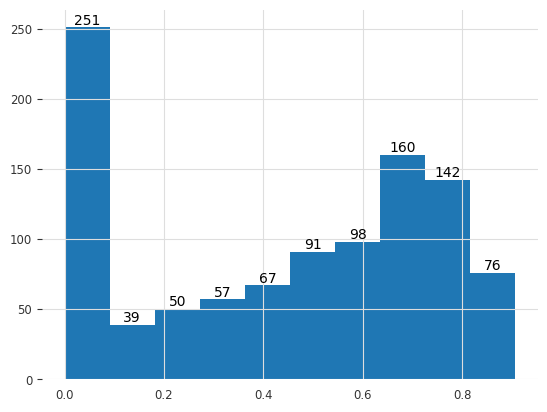

In [7]:
print(len(metrics_df[metrics_df['Accuracy_Score']>0]), metrics_df['Accuracy_Score'].mean())
counts, edges, bars = plt.hist(metrics_df['Accuracy_Score'], color = "#1f77b4")
plt.bar_label(container=bars)
plt.show()

In [ ]:
metrics_df.to_csv('Arima_score.csv')